In [1]:
import pandas as pd
import math
import datetime
import numpy as np
import pandas as pd
import random
import csv
import time

from snownlp import SnowNLP
from pandas.plotting import register_matplotlib_converters
from minepy import MINE
from math import log

from scipy.stats import spearmanr

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
plt.rcParams['font.family'] = ['SimHei'] #用来显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

import tensorflow as tf

from tensorflow.keras.layers import LSTM,Dense,Dropout#Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.datasets import load_iris

# 数据处理

In [2]:
df = pd.read_csv('783.csv',encoding = 'gbk')
df1 = pd.read_csv('11.29')
df2 = pd.read_csv('11.30')

In [3]:
df1 = df1.loc[df1['名称'] == '长江证券']
df2 = df2.loc[df2['名称'] == '长江证券']

In [4]:
df1

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量/手,成交额/万,股吧
41,sh600756,浪潮软件,12.64,-0.13,-1.018%,12.64,12.65,12.77,12.55,12.83,12.40,"131,510","16,557.92",http://guba.sina.com.cn/bar.php?name=sh688628


In [5]:
df2['成交量/手']

41    131,510
Name: 成交量/手, dtype: object

In [6]:
a = df1['涨跌幅'].str.extract(r'(.*?)(\d+)(.*?)(\d+)')
b = df2['涨跌幅'].str.extract(r'(.*?)(\d+)(.*?)(\d+)')

In [7]:
a = a[0]+a[1]+a[2]+a[3]
b = b[0]+b[1]+b[2]+b[3]

In [8]:
lst1 = pd.DataFrame({'日期':'2022-10-22','收盘价':df1['最新价'],'最高价':df1['最高'],
       '最低价':df1['最低'],'开盘价':df1['今开'],'涨跌幅':a})
lst2 = pd.DataFrame({'日期':'2022-10-23','收盘价':df2['最新价'],'最高价':df2['最高'],
       '最低价':df2['最低'],'开盘价':df2['今开'],'涨跌幅':b})

In [9]:
df.columns

Index(['日期', '股票代码', '名称', '收盘价', '最高价', '最低价', '开盘价', '前收盘', '涨跌额', '涨跌幅',
       '换手率', '成交量', '成交金额', '总市值', '流通市值'],
      dtype='object')

In [10]:
df.head()

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2022-10-21,'600756,浪潮软件,12.64,12.83,12.40,12.55,12.77,-0.13,-1.018,4.0577,13151009,165579182.0,4.096608e+09,4.096608e+09
1,2022-10-20,'600756,浪潮软件,12.77,13.25,12.45,12.51,12.50,0.27,2.16,6.6724,21625023,278376154.0,4.138741e+09,4.138741e+09
2,2022-10-19,'600756,浪潮软件,12.50,12.72,12.44,12.65,12.75,-0.25,-1.9608,3.5483,11499992,144412682.0,4.051234e+09,4.051234e+09
3,2022-10-18,'600756,浪潮软件,12.75,12.90,12.60,12.75,12.89,-0.14,-1.0861,3.8108,12350722,157454246.0,4.132259e+09,4.132259e+09
4,2022-10-17,'600756,浪潮软件,12.89,13.08,12.51,12.73,13.04,-0.15,-1.1503,8.5168,27602834,353134165.0,4.177633e+09,4.177633e+09


In [11]:
df.drop(['名称','股票代码','总市值','流通市值','涨跌额',#'涨跌幅','最高价','最低价',
         '前收盘','成交金额','换手率'],
        axis = 1,inplace = True)

In [12]:
df.columns

Index(['日期', '收盘价', '最高价', '最低价', '开盘价', '涨跌幅', '成交量'], dtype='object')

In [13]:
df.head()

,日期,收盘价,最高价,最低价,开盘价,涨跌幅,成交量
0,2022-10-21,12.64,12.83,12.40,12.55,-1.018,13151009
1,2022-10-20,12.77,13.25,12.45,12.51,2.16,21625023
2,2022-10-19,12.50,12.72,12.44,12.65,-1.9608,11499992
3,2022-10-18,12.75,12.90,12.60,12.75,-1.0861,12350722
4,2022-10-17,12.89,13.08,12.51,12.73,-1.1503,27602834


In [14]:
df = df.append(lst1)
df = df.append(lst2)
df.tail()

,日期,收盘价,最高价,最低价,开盘价,涨跌幅,成交量
6318,1996-09-25,11.5,12.28,11.5,12.2,-5.7377,1352000.0
6319,1996-09-24,12.2,12.5,11.61,11.85,2.0921,3860000.0
6320,1996-09-23,11.95,12.4,11.21,12.3,113.3929,6651900.0
41,2022-10-22,12.64,12.83,12.40,12.55,-1.018,NaN
41,2022-10-23,12.64,12.83,12.40,12.55,-1.018,NaN


In [15]:
df['日期'] = pd.to_datetime(df['日期'])
df = df.loc[df['日期']>datetime.datetime(2020,1,1)]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 41
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      680 non-null    datetime64[ns]
 1   收盘价     680 non-null    object        
 2   最高价     680 non-null    object        
 3   最低价     680 non-null    object        
 4   开盘价     680 non-null    object        
 5   涨跌幅     680 non-null    object        
 6   成交量     678 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 42.5+ KB


In [17]:
#重复值判断
df.index
df.duplicated()
df.drop_duplicates()
df['日期'].unique()

array(['2022-10-21T00:00:00.000000000', '2022-10-20T00:00:00.000000000',
       '2022-10-19T00:00:00.000000000', '2022-10-18T00:00:00.000000000',
       '2022-10-17T00:00:00.000000000', '2022-10-14T00:00:00.000000000',
       '2022-10-13T00:00:00.000000000', '2022-10-12T00:00:00.000000000',
       '2022-10-11T00:00:00.000000000', '2022-10-10T00:00:00.000000000',
       '2022-09-30T00:00:00.000000000', '2022-09-29T00:00:00.000000000',
       '2022-09-28T00:00:00.000000000', '2022-09-27T00:00:00.000000000',
       '2022-09-26T00:00:00.000000000', '2022-09-23T00:00:00.000000000',
       '2022-09-22T00:00:00.000000000', '2022-09-21T00:00:00.000000000',
       '2022-09-20T00:00:00.000000000', '2022-09-19T00:00:00.000000000',
       '2022-09-16T00:00:00.000000000', '2022-09-15T00:00:00.000000000',
       '2022-09-14T00:00:00.000000000', '2022-09-13T00:00:00.000000000',
       '2022-09-09T00:00:00.000000000', '2022-09-08T00:00:00.000000000',
       '2022-09-07T00:00:00.000000000', '2022-09-06

In [18]:
#缺失值判断
#df.isnull().any()
df.isnull().sum()
df.fillna(str(df['成交量'].mean()),inplace=True)
#df.fillna(str(df['收盘价'].mean()))

In [19]:
#删除0值行
df = df.loc[(df['收盘价']!=0)]

In [20]:
df.reset_index(inplace=True,drop=True)
df.set_index('日期',inplace=True)
df.index
df.head()
df.tail()

,收盘价,最高价,最低价,开盘价,涨跌幅,成交量
日期,,,,,,
2020-01-06,21.28,21.45,21.0,21.1,0.6147,9565708.0
2020-01-03,21.15,21.21,20.86,21.1,0.237,7791816.0
2020-01-02,21.1,21.14,20.71,20.78,2.0309,8309978.0
2022-10-22,12.64,12.83,12.40,12.55,-1.018,9273070.272861358
2022-10-23,12.64,12.83,12.40,12.55,-1.018,9273070.272861358


In [21]:
k = df.pop('开盘价')
s = df.pop('收盘价')
df.insert(0,'开盘价',k)
df.insert(5,'收盘价',s)
df.sort_index()
df['涨跌幅'].astype('float64')
df['成交量'].astype('float64')

日期
2022-10-21    1.315101e+07
2022-10-20    2.162502e+07
2022-10-19    1.149999e+07
2022-10-18    1.235072e+07
2022-10-17    2.760283e+07
                  ...     
2020-01-06    9.565708e+06
2020-01-03    7.791816e+06
2020-01-02    8.309978e+06
2022-10-22    9.273070e+06
2022-10-23    9.273070e+06
Name: 成交量, Length: 680, dtype: float64

In [22]:
df.to_csv('长江证券.csv')

# 文本分析

In [23]:
file=pd.read_csv('文本.csv')
file1=pd.read_csv('长江证券.csv')
df=pd.DataFrame(file)
lc=pd.DataFrame(file1)
df2=df.iloc[2:290,:]
df2=df2.drop(index=df2[(df2.flag=="flag")].index.tolist())
df2=df2.reset_index(drop=True)

In [24]:
b=[]
a=[]
for i in df2["title"]:
    a.append(SnowNLP(i).sentiments)
df2["a"]=a
for i in df2["remark"]:
    b.append(log(int(i),2))
df2["b"]=b
df2["SentimentScore"]=df2[["a","b"]].apply(lambda x:x["a"]+x["b"],axis=1)
df2=df2.drop(["a"],axis=1)
df2=df2.drop(["b"],axis=1)
df2

,Unnamed: 0,title,time,author,flag,remark,SentimentScore
0,2.0,\n我看空 浪潮软件(SH600756)[我,09月01日,\ntiger05262410\n,0,374,8.909515
1,3.0,\n我看空 浪潮软件(SH600756)[我,08月31日,\n碧哩bilipapapa\n,0,411,9.045615
2,4.0,\n我看空 浪潮软件(SH600756)[我,08月30日,\ntiger05262410\n,0,371,8.897896
3,5.0,\n#今日看盘[超话]#昨晚就有数据的利好,06月24日,\n碧哩bilipapapa\n,0,936,10.523901
4,6.0,\n看涨,06月21日,\n用户6383684789\n,0,625,9.787712
...,...,...,...,...,...,...,...
279,41.0,\n1月26日,02月02日,\n用户5482766184\n,0,7647,12.970069
280,42.0,\n原本算的开盘跌的概率是70，看到这么多利好资讯,02月02日,\n湖南股友\n,0,1016,10.019692
281,43.0,\n1月25日，大年初一，云南省政府致电浪潮,02月01日,\n用户5482766184\n,0,2027,10.988084
282,44.0,\n这场“战疫”会改变中国人开会习惯吗？比口罩更热门的援赠,01月31日,\n湖南股友\n,0,5316,13.341477


In [25]:
lc.head()

,日期,开盘价,最高价,最低价,涨跌幅,成交量,收盘价
0,2022-10-21,12.55,12.83,12.40,-1.0180,13151009.0,12.64
1,2022-10-20,12.51,13.25,12.45,2.1600,21625023.0,12.77
2,2022-10-19,12.65,12.72,12.44,-1.9608,11499992.0,12.50
3,2022-10-18,12.75,12.90,12.60,-1.0861,12350722.0,12.75
4,2022-10-17,12.73,13.08,12.51,-1.1503,27602834.0,12.89


In [26]:
c=[]
d=[]
for i in lc["成交量"]:
    c.append(int(i))
for i in df2["SentimentScore"]:
    d.append(i)
len(d)
e=random.sample(c,284)
e.sort(key=c.index)
spearmanr(e,d)

SpearmanrResult(correlation=0.20082563448386054, pvalue=0.0006635959722788152)

In [27]:
mine = MINE(alpha=0.6, c=15)
mine.compute_score(e, a)
print(mine.mic())

0.18003484115159554


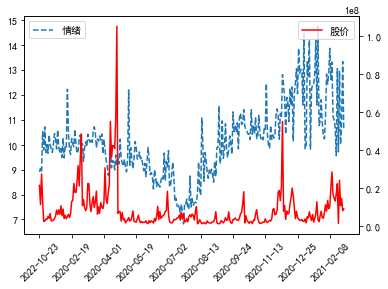

In [28]:
v=lc["日期"].tail(284)
x=[]
for i in v:
    x.append(i)
x.reverse()
plt.plot(x,df2['SentimentScore'],linestyle='--',label='情绪')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.twinx()
plt.plot(x,e,color='red',label='股价')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=30))
plt.show()

# 数据预测

In [29]:
df = pd.read_csv('浪潮软件.csv')
df.reset_index(inplace = True,drop = True)
df.set_index('日期',inplace =True)
df.sort_index(ascending = True,inplace = True)

df.head()

,开盘价,最高价,最低价,涨跌幅,成交量,收盘价
日期,,,,,,
2020-01-02,20.78,21.14,20.71,2.0309,8309978.0,21.10
2020-01-03,21.10,21.21,20.86,0.2370,7791816.0,21.15
2020-01-06,21.10,21.45,21.00,0.6147,9565708.0,21.28
2020-01-07,21.30,21.80,21.18,1.6917,12919033.0,21.64
2020-01-08,21.45,21.53,20.94,-3.1423,10962888.0,20.96


In [30]:
def scale(train_data,test_data):
    #归一化：缩放至（0，1）之间
    sc = MinMaxScaler(feature_range=(0,1))
    #训练缩放器
    sc = sc.fit(train_data)
    #缩放数据
    train_data_scale = sc.fit_transform(train_data)
    test_data_scale = sc.transform(test_data)
    
    
    return sc,train_data_scale,test_data_scale

#训练模型
def LSTMmodel(x_train,y_train,epochs):
    #输入、输出
    x_train,y_train = np.array(x_train),np.array(y_train)
    x_train = np.reshape(x_train,(x_train.shape[0],60,6))
    
    model = tf.keras.Sequential()
    
    model.add(LSTM(80,return_sequences=True))
    model.add(Dropout(0.2))
    #丢弃比0.2
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    
    model.add(Dense(6))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss = 'mean_squared_error')
    #model.fit(输入数据，标签，进行梯度下降时每个batch包含样本数，迭代次数，)
    history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, verbose=1,validation_split=0.2,validation_freq=1,shuffle=False)
    # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
    model.reset_states()
    model.summary()
    
    return model,history

#单步预测
def LSTMpredict(model,batch_size,x_test):
    x_test = np.array(x_test)
    x_test = np.reshape(x_test,(x_test.shape[0],60,6))
    predicted_stock_price = model.predict(x_test,batch_size=batch_size)
    
    return predicted_stock_price

#反归一化
def inverse_scale(sc,data):
    #开盘价	最高价	最低价	涨跌幅	成交量	收盘价
    data_predict = sc.inverse_transform(data)
    
    return data_predict


#数据输入特征
def g1(train_data_scale,test_data_scale):
     #归一化，输入特征x_train
    x_train = []
    y_train = []
    for i in range(60,len(train_data_scale)):
        x_train.append(train_data_scale[i-60:i])
        y_train.append(train_data_scale[i])
    #归一化,输入特征x_test
    x_test = []
    y_test = []
    for i in range(60,len(test_data_scale)):
        x_test.append(test_data_scale[i-60:i])
        y_test.append(test_data_scale[i])
    
    return x_train,x_test,y_train,y_test

In [31]:
if __name__ == '__main__':
    
    #划分训练集与测试集
    train_end_index = math.floor(len(df)*0.7) 
    s = df.values
    train_data ,test_data = s[:train_end_index],s[train_end_index:]
    
    sc,train_data_scale,test_data_scale = scale(train_data,test_data)
    x_train,x_test,y_train,y_test = g1(train_data_scale,test_data_scale)
    m,history = LSTMmodel(x_train,y_train,200)
    predicted_test = LSTMpredict(m,64,x_test)
    predicted_train = LSTMpredict(m,64,x_train)
    predicted_test = inverse_scale(sc,predicted_test)
    real_test = inverse_scale(sc,test_data_scale[60:])
    predicted_train = inverse_scale(sc,predicted_train)
    real_train = inverse_scale(sc,train_data_scale[60:])

Epoch 1/200
6/6 [==============================] - 5s 248ms/step - loss: 0.1341 - val_loss: 0.0185
Epoch 2/200
6/6 [==============================] - 1s 87ms/step - loss: 0.0310 - val_loss: 0.0181
Epoch 3/200
6/6 [==============================] - 1s 92ms/step - loss: 0.0202 - val_loss: 0.0120
Epoch 4/200
6/6 [==============================] - 1s 102ms/step - loss: 0.0146 - val_loss: 0.0056
Epoch 5/200
6/6 [==============================] - 1s 95ms/step - loss: 0.0126 - val_loss: 0.0044
Epoch 6/200
6/6 [==============================] - 1s 86ms/step - loss: 0.0120 - val_loss: 0.0043
Epoch 7/200
6/6 [==============================] - 1s 99ms/step - loss: 0.0110 - val_loss: 0.0031
Epoch 8/200
6/6 [==============================] - 0s 81ms/step - loss: 0.0111 - val_loss: 0.0031
Epoch 9/200
6/6 [==============================] - 1s 93ms/step - loss: 0.0146 - val_loss: 0.0052
Epoch 10/200
6/6 [==============================] - 1s 87ms/step - loss: 0.0116 - val_loss: 0.0032
Epoch 11/200
6/6 

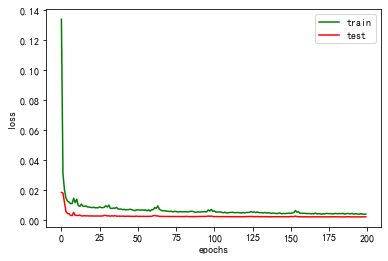

MSE: 0.20817346657971486
RMSE: 0.45626030572439114
MAE: 0.3312715811893857
MAPE: 0.025402963506669467
R^2_test: 0.8004661780347839
R^2_train: 0.9811645773245503


In [32]:
"""
损失图绘制，寻找最优epochs
:param _history: 训练历史
:param title: 图表标题

"""
plt.plot(history.history['loss'], color='g', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# 保存于 补充数据1925102007/
#savingPath = '损失图.png'
# plt.savefig(savingPath, dpi=400, bbox_inches='tight')
# 展示
plt.show()

MSE = mean_squared_error(predicted_test[:,-1],real_test[:,-1])
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(predicted_test[:,-1],real_test[:,-1])
MAPE = mean_absolute_percentage_error(predicted_test[:,-1],real_test[:,-1])
RR_test = r2_score(real_test[:,-1],predicted_test[:,-1])
RR_train = r2_score(real_train[:,-1],predicted_train[:,-1])
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)
print('R^2_test:',RR_test)
print('R^2_train:',RR_train)

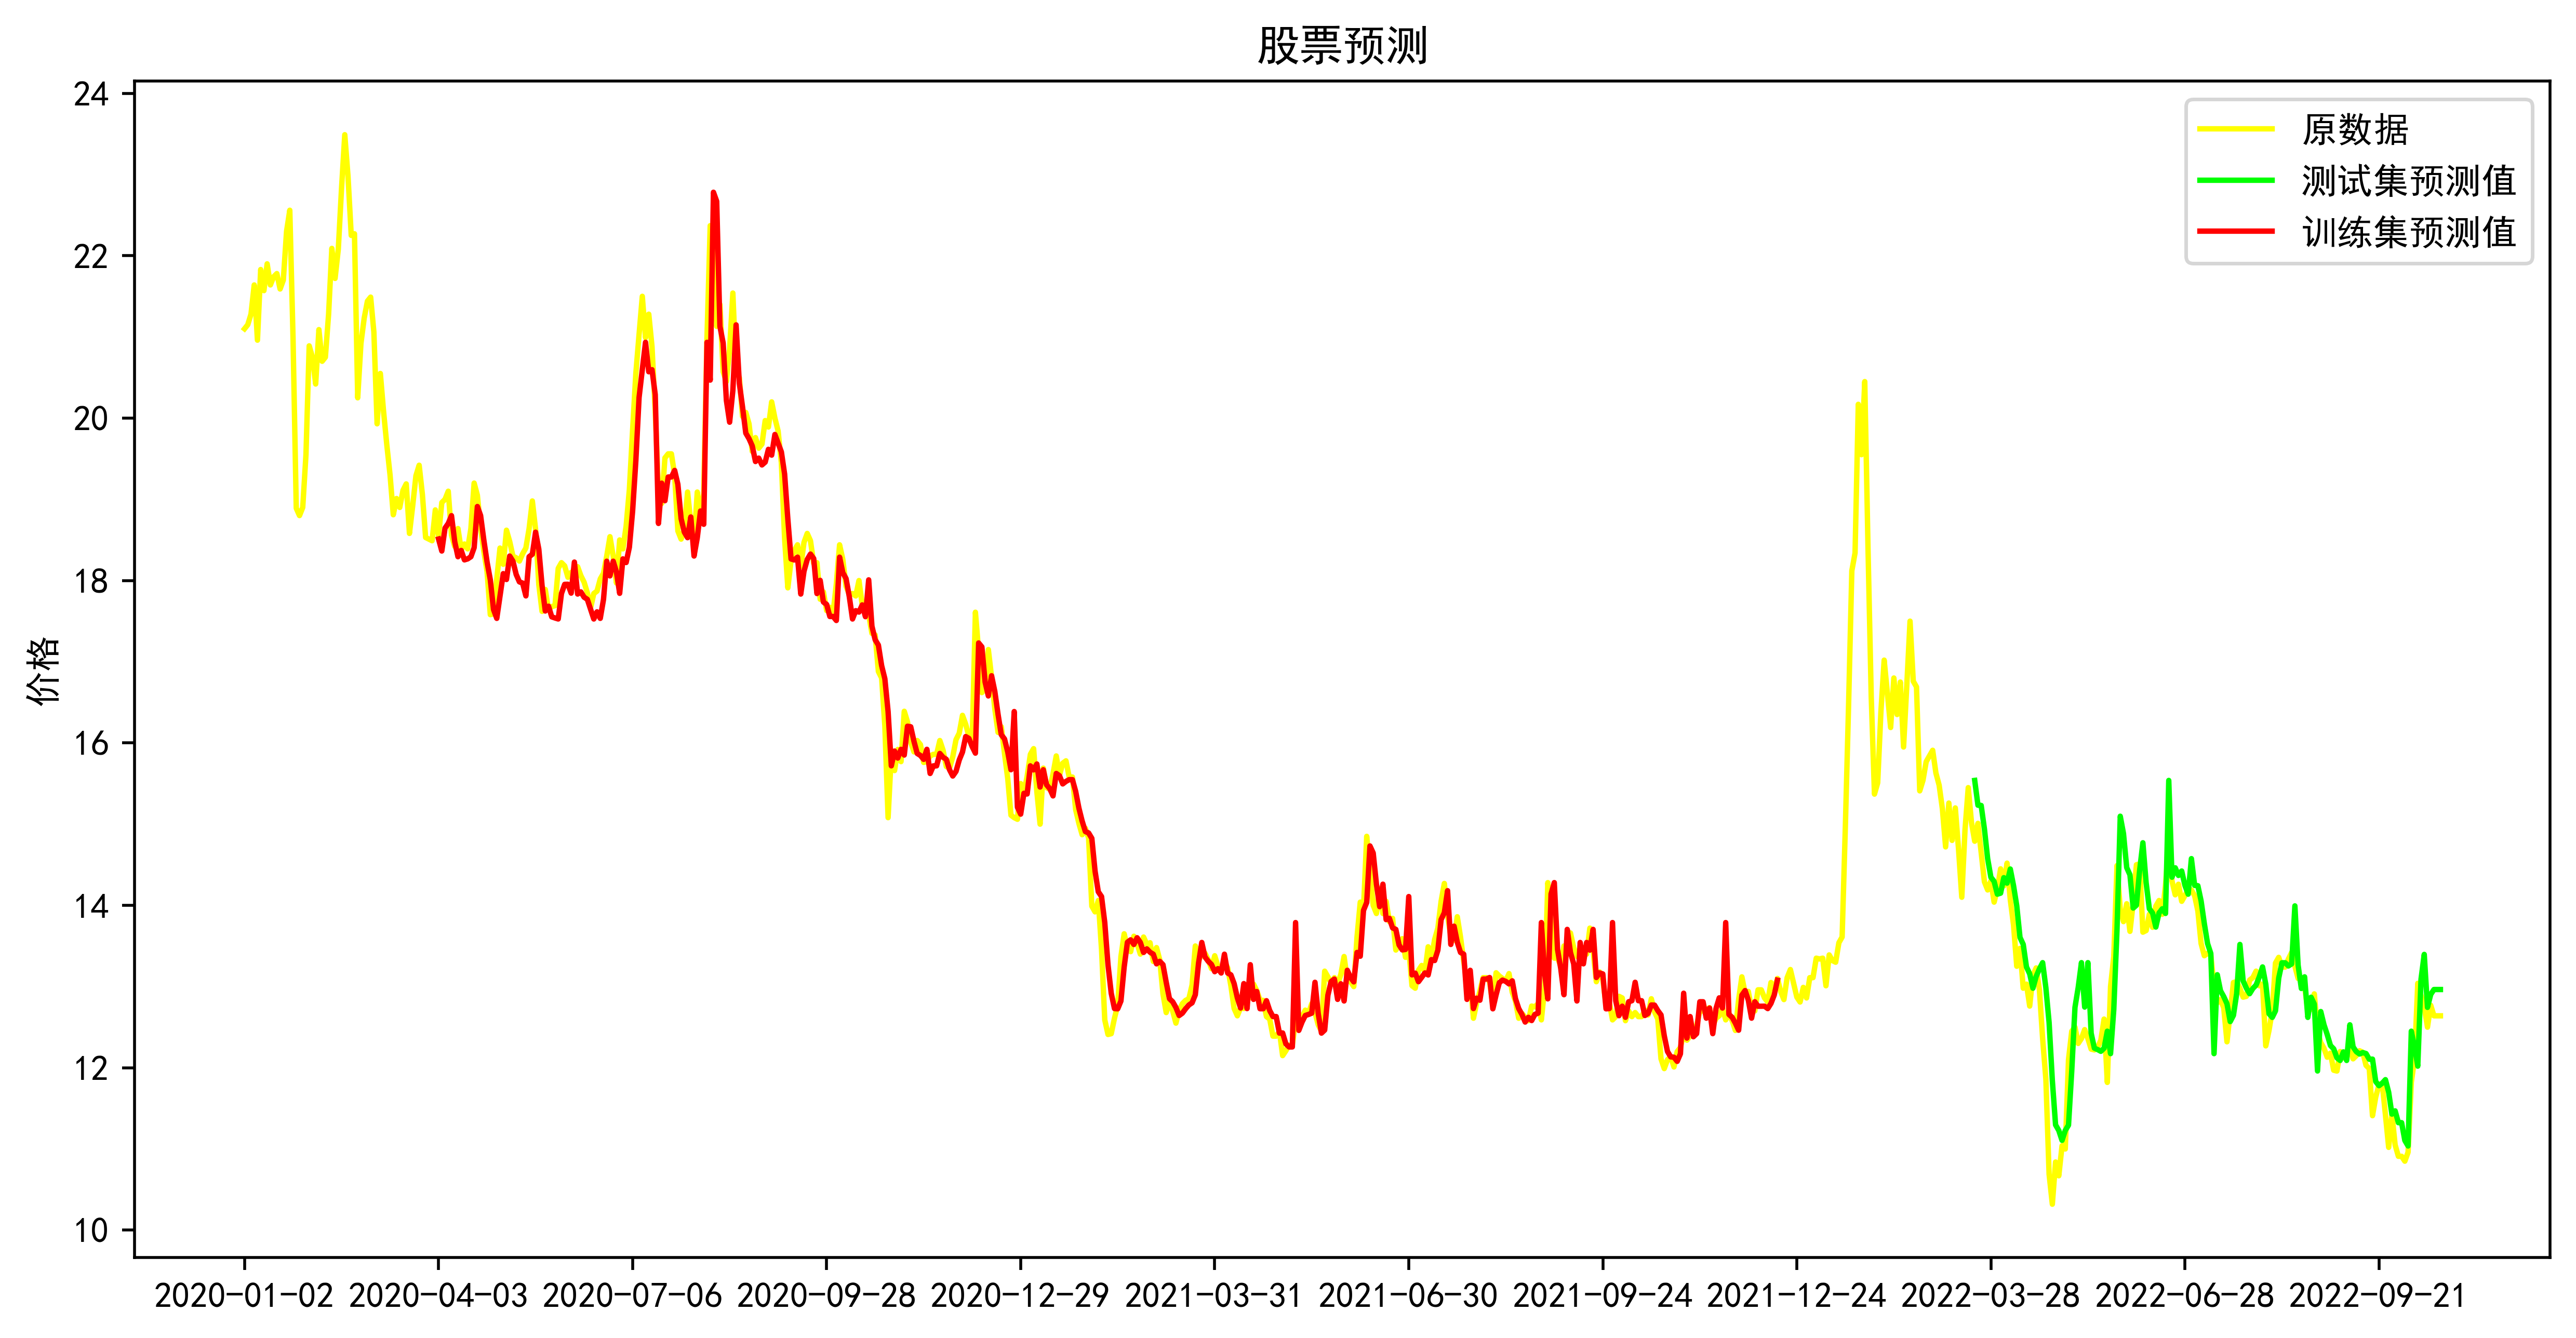

In [33]:
df1 = df[train_end_index+60:]
df1 = df1.replace(df1['收盘价'].values,predicted_test[:,-1],regex=True)
df_left = pd.merge(df['收盘价'],df1['收盘价'],how='left',on='日期')
df2 = df[60:train_end_index]
df2 = df2.replace(df2['收盘价'].values,predicted_train[:,-1],regex=True)
df_e = pd.merge(df_left,df2['收盘价'],how='left',on='日期')
fig = plt.figure(figsize=(12,6),dpi=500)
#df_left.plot(ylabel='价格')
plt.plot(df_e['收盘价_x'],color='yellow',label='原数据')
plt.plot(df_e['收盘价_y'],color='lime',label='测试集预测值')
plt.plot(df_e['收盘价'],color='red',label='训练集预测值')
plt.legend()
plt.ylabel('价格')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=60))
plt.title("股票预测")
plt.show()